In [10]:


%load_ext autoreload
%autoreload 2
%load_ext line_profiler


import numpy as np
import DemandEstimation_v2 as DE
from tqdm.notebook import tqdm
from statsmodels.regression.linear_model import OLS 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Doing a simulation study: 

In [36]:
def sim_study(sim_params,cov, Type = "OLS", Consts = False, tqdm_off = False):
    """
    Type - options "OLS", "IV"
    """
    f,j,k,T,Q = sim_params

    # No. of Firms, products and traits: 
    #f=2 # Firms
    #j=3 # Products
    #k=3 # Traits (of each product) 
    
    # True Parameters 
    alpha = -5                      # Price sensitivity
    beta= np.array([3,2,1])         # Preference for traits 
    theta = np.append(alpha,beta)   
    gamma = np.array([1,2,3])       # Production costs of traits 

    #cov = np.array([[1,0.5],[0.5,1]])
    T = 100

    if Type == "OLS":
        if Consts == True: 
            parameters = np.zeros((Q,1 + k*2 + f*j*2)) + np.nan
        else:
            parameters = np.zeros((Q,k + 1)) + np.nan

    elif Type == "IV":
        parameters = np.zeros((Q, k+1))

    for q in tqdm(range(Q),disable = tqdm_off): 
        try:
            
            data = DE.endog_data()
            X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
            H = data.hadamard(f*j,prod)
            X = X.reshape(j*f, -1)

            # Simulate data 
            S = np.array(0) 
            while S.min() == 0.0:
                P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod, H, disable = True)
            S.min()

            S0=(1-np.sum(S,axis=0))

            index=np.log(S/S0).reshape(-1,1)

            #Estimation: 
            if Type == "OLS": 

                # OLS with endogenous prices
                P1 = P.reshape(-1,1)

                if Consts == True: 
                    j_const = np.identity(f*j).repeat(T, axis=0)
                    XX = np.hstack((P1, X.repeat(T, axis=0),j_const))
                else: 
                    XX = np.hstack((P1, X.repeat(T, axis=0)))

                resultsp=OLS(index,XX).fit()
                results = resultsp.params
            
                parameters[q,:] = results
            
            elif Type == "IV":
                parameters[q,:] = data.blp_regression(index, P, X, prod, [f,j,T])

                if np.abs(parameters[q,0]) > 20: 
                    print(parameters[q,0])
                    print("P", P.max(), P.min())
                    print("S", S.max(), S.min())
                
        except np.linalg.LinAlgError: 
            print("linalg error")
            break
    return parameters




    


#### BLP approach. Do the following regression:
$\delta_{jm} =\beta V(X, p_{jm} ) + \psi_{jm}$ 

This regression is intractable so instead estimate by IV. 

##### Comment: I do not need to simulate new data. I can just run the two approaches on the same data

#### Simulating data

In [11]:

f,j,k,T,Q = 2,3,3,10,100

sim_params = [f,j,k,T,Q]

cov = np.array([[1,0.50],[0.50,1]])
corr=sim_study(sim_params, cov, Type = "OLS", Consts = False)
corr_IV = sim_study(sim_params, cov, Type = "IV")

cov = np.array([[1,0.0],[0.0,1]])
wo_corr = sim_study(sim_params,cov, Type = "OLS", Consts = False)
wo_corr_IV = sim_study(sim_params,cov, Type = "IV")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
wo_corr_pd = pd.DataFrame(wo_corr)
wo_corr_pd_IV = pd.DataFrame(wo_corr_IV)
corr_pd = pd.DataFrame(corr)
corr_pd_IV = pd.DataFrame(corr_IV)


In [16]:
pd.DataFrame([wo_corr_pd.mean(axis=0),wo_corr_pd_IV.mean(axis=0), corr_pd.mean(axis=0), corr_pd_IV.mean(axis=0)])

,0,1,2,3
0,-5.003933,2.986312,2.018430,0.998066
1,-5.014658,3.039104,2.016862,1.044204
2,-4.721040,2.627487,1.404934,0.140019
3,-4.965846,2.992709,1.949084,0.861684


In [9]:
pd.DataFrame([wo_corr_pd.median(axis=0),wo_corr_pd_IV.median(axis=0), corr_pd.median(axis=0), corr_pd_IV.median(axis=0)])

,0,1,2,3
0,-4.999633,2.986026,2.003665,1.008292
1,-5.013714,3.038539,2.028530,0.984123
2,-4.715158,2.644176,1.320423,0.099978
3,-4.954651,2.894434,1.864687,0.765891


Results so far: 

With parameters 

0	1	2	3
0	-3.000049	1.004966	0.994198	1.995436
1	-2.992413	0.999941	0.978292	1.976096
2	-2.994373	0.978406	0.996163	2.002496
3	-3.002868	1.007717	0.992143	2.007656




In [ ]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]


fig, ax =plt.subplots(1,3)
sns.histplot(wo_corr_pd[0], ax=ax[0])
sns.histplot(wo_corr_pd[1], ax=ax[1]).set(title='OLS without Correlation')
sns.histplot(wo_corr_pd[2], ax=ax[2])


fig.show()

In [ ]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]


fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd_IV[0], ax=ax[0])
sns.histplot(corr_pd_IV[1], ax=ax[1]).set(title='IV without Correlation')
sns.histplot(corr_pd_IV[2], ax=ax[2])


fig.show()

In [ ]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1]).set(title='OLS with Correlation')
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

In [ ]:
wo_corr_pd.mean()

In [ ]:
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd_IV[0], ax=ax[0])
sns.histplot(corr_pd_IV[1], ax=ax[1]).set(title='IV with Correlation')
sns.histplot(corr_pd_IV[2], ax=ax[2])

fig.show()

In [ ]:
corr_pd_IV.mean()

In [ ]:
corr_pd = pd.DataFrame(corr_IV)
corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1])
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

#### Consistency study

In [42]:
N = 20
skip = 20
price_param = np.zeros((N,4)) + np.nan
price_param_med = np.zeros((N,4)) + np.nan

for n in tqdm(range(N)):
    T=(n+1)*skip 

    f,j,k,T,Q = 2,3,3,T,100

    sim_params = [f,j,k,T,Q]

    cov = np.array([[1,0.50],[0.50,1]])
    corr=sim_study(sim_params, cov, Type = "OLS", Consts = False, tqdm_off=True)
    corr_IV = sim_study(sim_params, cov, Type = "IV", tqdm_off=True)

    cov = np.array([[1,0.0],[0.0,1]])
    wo_corr = sim_study(sim_params,cov, Type = "OLS", Consts = False, tqdm_off=True)
    wo_corr_IV = sim_study(sim_params,cov, Type = "IV", tqdm_off=True)

    price_param[n,:]=wo_corr[:,0].mean(), wo_corr_IV[:,0].mean(), corr[:,0].mean(), corr_IV[:,0].mean()
    price_param_med[n,:] = np.median(wo_corr[:,0]), np.median(wo_corr_IV[:,0]), np.median(corr[:,0]), np.median(corr_IV[:,0])

  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\glh287\AppData\Local\Temp/ipykernel_17288/1805616327.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((np.arange(N)+1)*f*j*skip, rotation=-45)


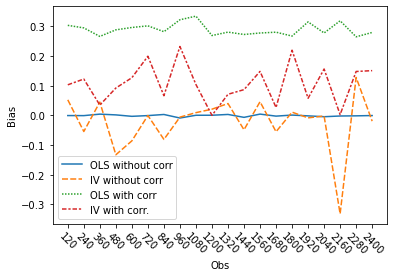

In [43]:
sim_data=pd.DataFrame(data =price_param + 5, columns = ["OLS without corr", "IV without corr", "OLS with corr", "IV with corr."])
ax = sns.lineplot(data=sim_data)
ax.set(xlabel='Obs', ylabel='Bias',)
ax.set_xticklabels((np.arange(N)+1)*f*j*skip, rotation=-45)
ax.set_xticks(np.arange(N))
plt.show()


C:\Users\glh287\AppData\Local\Temp/ipykernel_17288/2038273903.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((np.arange(N)+1)*f*j*skip, rotation=-45)


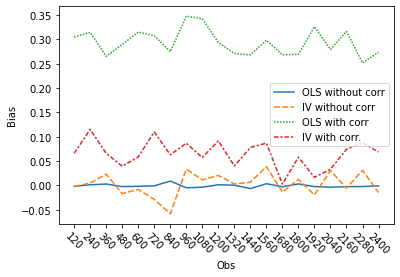

In [44]:
sim_data_med=pd.DataFrame(data =price_param_med + 5, columns = ["OLS without corr", "IV without corr", "OLS with corr", "IV with corr."])
ax = sns.lineplot(data=sim_data_med)
ax.set(xlabel='Obs', ylabel='Bias')
ax.set_xticklabels((np.arange(N)+1)*f*j*skip, rotation=-45)
ax.set_xticks(np.arange(N))
plt.show()


#### Conclusion:
Instruments do not seem to be consistent as T goes to inf? 